In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import latools as la
import pandas as pd
import uncertainties as un
import uncertainties.unumpy as unp

In [2]:
dir = 'dev_boron/carbonates_clean'
file = dir + '/20220223_001_v2_CarbTest_Standards.xlsx'
la.preprocessing.sanitise.Neptune_xlsx(file, 25000)

'Saved to: dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv'

In [3]:
# from latools import preprocessing
# file = 'dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv'
# preprocessing.split.by_regex(file, outdir=dir, split_pattern='Neptune Analysis Data Report', fname_pattern='Block-View - (Block: \d+).*')



In [4]:
dataformat = {
    "genfromtext_args": {
    "delimiter": ",",
    },
    "column_id": {
        "delimiter": ",",
        "timecolumn": 0,
        "name_row": 0,
        "pattern": "([0-9]{1,3}[A-z]{1,3}|[0-9.]{2,})"
    }}

In [5]:
laserlog = pd.read_csv(dir + '/20220223_CarbTest_Standards_log_20220223_190001.laserlog')
laserlog.columns = [s.strip() for s in laserlog.columns]
sample_names = laserlog.Comment.dropna().values
# sample_names = sample_names[:22]

In [6]:

# la.preprocessing.split.long_file(file.replace('xlsx','csv'), dataformat=dataformat, sample_list=sample_names, plot=True, analyte='10B', savedir=dir + '/split', passthrough=False, **autorange_args)


In [7]:
autorange_args = {
    'signal_id_mode': 'polynomial',
    'poly_noise_level': 2.5, 
    'poly_order': 3, 
    'std_above_baseline': 3, 
    'min_points': 3,
    'swin': 3,
    'transform': None,
    'plot': True,
}

dat = la.analyse(file.replace('xlsx','csv'), dataformat=dataformat, file_structure='long', names=sample_names, split_kwargs=autorange_args, srm_identifier='NIST', srm_file='latools/resources/SRM_GeoRem_Preferred_100523.csv')

--------------------------------------------------------------------------------
Starting analysis:
  Using custom srm_file (latools/resources/SRM_GeoRem_Preferred_100523.csv)
  Using custom dataformat dict


0it [00:00, ?it/s]

/home/oscar/GitHub/latools/dev_boron/carbonates_clean/20220223_001_v2_CarbTest_Standards.csv
dataformat dict provided - no read necessary.
Number of samples in list (171) does not match number of ablations (174).
  -> There are more ablations than samples...
     Removing data fragments to match sample list length.
       (Removed data fragments < 6 points long)
Success! 171 ablations identified.
Loading Data:
  171 Data Files Loaded: 16 standards, 155 samples
Analytes: 9.95 10.54 10B 10.115 11B
  Internal Standard: None


In [8]:
dat.despike()

Despiking:   0%|          | 0/171 [00:00<?, ?it/s]

In [9]:
dat.autorange('10B', swin=3, transform=None, signal_id_mode='polynomial', poly_noise_level=2., poly_order=3, std_above_baseline=3, on_mult=(3,1), off_mult=(1,3), mode='global', min_points=6)

In [10]:
# dat.trace_plots(ranges=True)

In [11]:
dat.bkg_calc_weightedmean(weight_fwhm=1500)

Plotting backgrounds:   0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 5130x750 with 1 Axes>,
 <Axes: title={'center': 'Points = raw data; Bars = stderr; Lines = Calculated Background; Envelope = Background stderr'}, xlabel='Time (s)', ylabel='Background Counts'>)

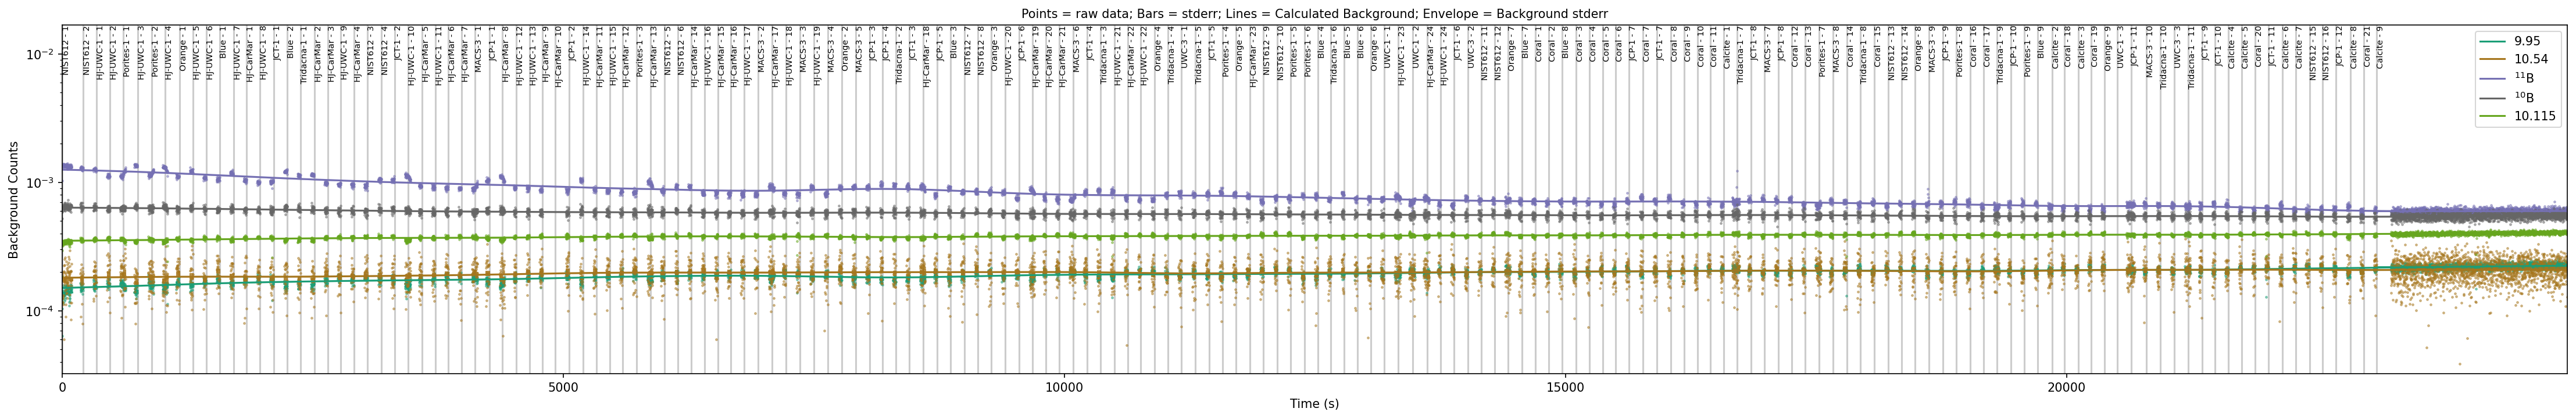

In [12]:
dat.bkg_plot()

In [13]:
dat.bkg_subtract()

Background Subtraction:   0%|          | 0/171 [00:00<?, ?it/s]

In [14]:
dat.analytes

{'10.115', '10.54', '10B', '11B', '9.95'}

In [173]:
dat.ratio(internal_standard='10B', analytes='11B')

# mass bias correction to NIST SRM

#   11B and 10B in SRM databse - calibrate function needs to be able to cope with analyte ratios in database.
#   Should just work with 'Calibrate' function? 
#   Is linear interpolation of parameters sensible? 
#   Think about sensitivity drift correction?

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

In [177]:
dat.clear_calibration()

In [181]:
dat.calibrate(drift_correct='gauss_weighted', srms_used='NIST612', gauss_weight_fwhm=7000, reload_srm_database=True)

  NIST612: 10.115
  NIST612: 10.115


Applying Calibrations:   0%|          | 0/171 [00:00<?, ?it/s]

In [186]:
# calculate d11B (or 11/10 Ratio) multiplicative correction factor
# apply offset multiplier to mass-bias corrected data

dat.ratio(internal_standard='10.115', analytes='11B')
# dat.ratio(internal_standard='10.54', analytes='11B')
# dat.ratio(internal_standard='9.95', analytes='11B')

Ratio Calculation:   0%|          | 0/171 [00:00<?, ?it/s]

In [147]:
tmp = dat.data['Blue - 1'].data['ratios'][a].copy()

In [184]:
# dat.drift_correct(analytes='11B_10.115', focus_stage='ratios', srms_used='NIST612', gauss_weight_fwhm=5000)

***NOPE***
A subset containing those samples already exists, and is called
'b_correction_srms'. A new subset has not been created. I suggest you use the
existing one. If you'd like to go ahead anyway, set `force=True` to make a new
subset with your provided name.


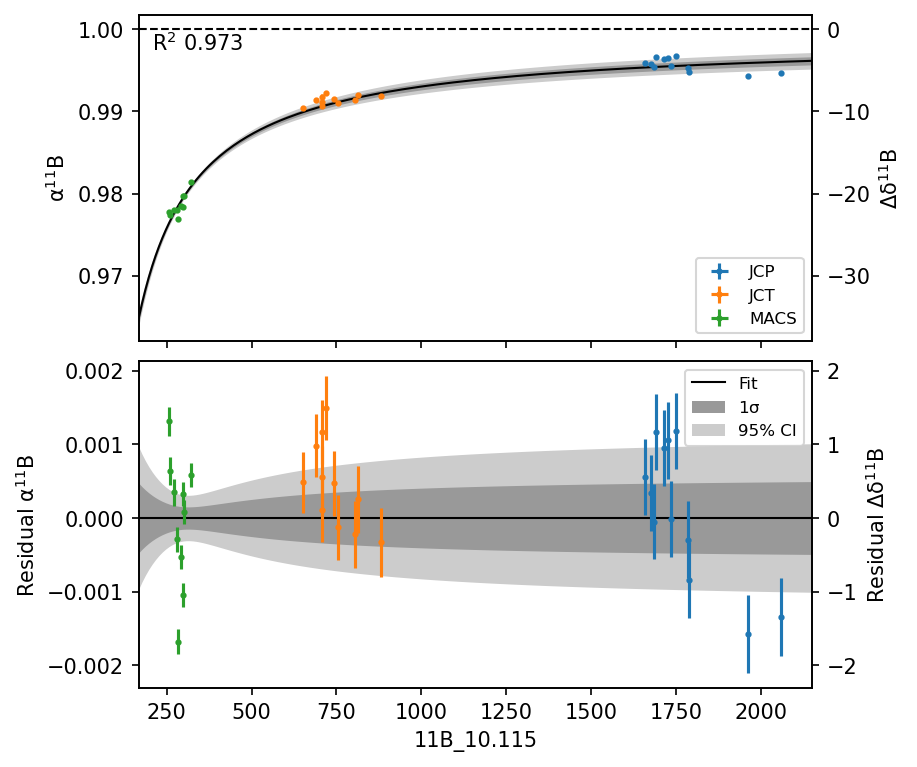

In [187]:
b_correction_srms = ['MACS', 'JCT', 'JCP']

correct_d11b_Ca_offset(dat, xvar='11B_10.115', b_correction_srms=b_correction_srms, yvar='11B_10B', uncertainty_metric='SE')


$$
y = \frac{a x}{1 - a x} + b
$$

In [188]:
from latools.processes.b_isotopes import R_to_delta

Text(0, 0.5, 'Corrected $\\delta^{11}B$')

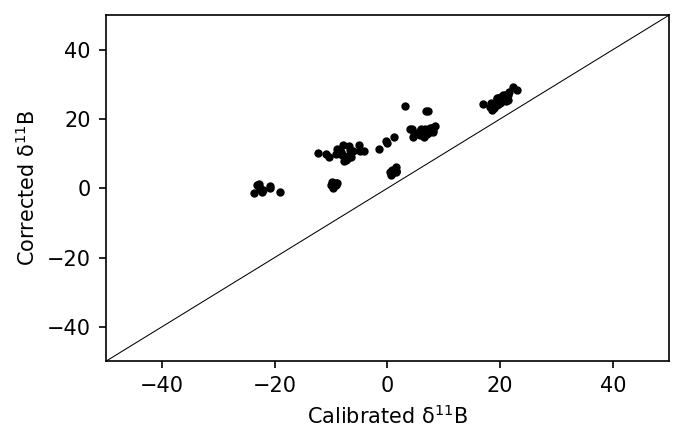

In [189]:
fig, ax = plt.subplots()

for s, d in dat.data.items():
    x = R_to_delta(np.nanmean(d.data['calibrated']['11B_10B']))
    y = R_to_delta(np.nanmean(d.data['d11b_corrected']['11B_10B']))
    
    ax.errorbar(x.nominal_value, y.nominal_value, xerr=x.std_dev, yerr=y.std_dev, fmt='o', c='k', markersize=3)

lim = -50, 50
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, c='k', lw=0.5)

ax.set_xlabel('Calibrated $\delta^{11}B$')
ax.set_ylabel('Corrected $\delta^{11}B$')

# ax.set_xlim(3.8, 4.8)
# ax.set_ylim(3.8, 4.8)

In [190]:
dat.sample_stats(analytes='11B_10B')

Calculating Stats:   0%|          | 0/155 [00:00<?, ?it/s]

In [221]:
s = dat.getstats()
stats = pd.DataFrame(index=s.loc['mean'].index, columns=['11B_10B'], data=unp.uarray(s.loc['mean',:], s.loc['std',:]))

stats['d11B'] = R_to_delta(stats['11B_10B'])
stats.index = stats.index.droplevel('rep')

(-20.0, 50.0)

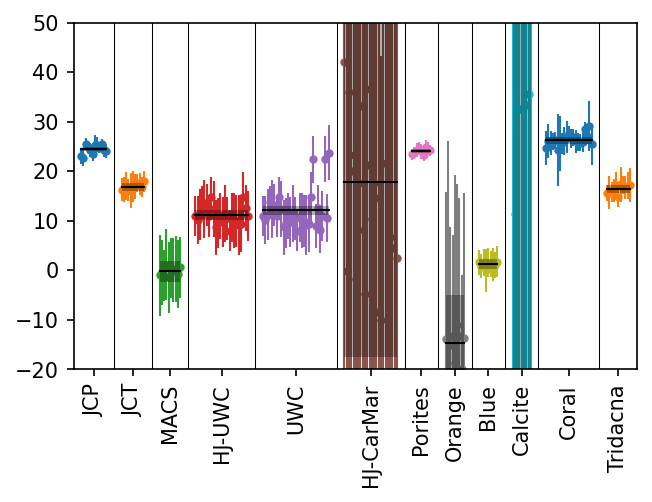

In [252]:
sample_types = [
    'JCP',
    'JCT',
    'MACS',
    'HJ-UWC',
    'UWC',
    'HJ-CarMar',
    'Porites',
    'Orange',
    'Blue',
    'Calcite',
    'Coral',
    'Tridacna'
]

fig, ax = plt.subplots()

x0 = 0
spacing = 0.3
padding = 2

lines = []
ticks = []

for st in sample_types:
    ind = stats.index.str.contains(st)
    sub = stats.loc[ind, :]
    n = sub.shape[0]
    
    x = x0 + np.arange(n) * spacing
    y = sub['d11B']
    
    ymean = np.nanmean(sub['d11B'])
        
    ax.errorbar(x, unp.nominal_values(y), yerr=unp.std_devs(y), fmt='o', markersize=3, lw=1, zorder=-1)
    ax.plot(x, [ymean.nominal_value] * n, c='k', lw=1)
    ax.fill_between(x, [ymean.nominal_value - ymean.std_dev] * n, [ymean.nominal_value + ymean.std_dev] * n, color='k', alpha=0.3, lw=0)

    ticks.append(x.mean())
    
    lines.append(max(x) + padding / 2)
    x0 = max(x) + padding

for line in lines[:-1]:
    ax.axvline(line, c='k', lw=0.5)
ax.set_xlim(-padding/2, x0-padding/2)

ax.set_xticks(ticks)
ax.set_xticklabels(sample_types, rotation=90)

ax.set_ylim(-20, 50)

In [226]:
sub

,11B_10B,d11B
sample,,


In [216]:
stats.index.get_level_values('sample').values

array(['HJ-UWC-1 - 1', 'HJ-UWC-1 - 2', 'Porites-1 - 1', 'HJ-UWC-1 - 3',
       'Porites-1 - 2', 'HJ-UWC-1 - 4', 'Orange - 1', 'HJ-UWC-1 - 5',
       'HJ-UWC-1 - 6', 'Blue - 1', 'HJ-UWC-1 - 7', 'HJ-CarMar - 1',
       'HJ-UWC-1 - 8', 'JCT-1 - 1', 'Blue - 2', 'Tridacna-1 - 1',
       'HJ-CarMar - 2', 'HJ-CarMar - 3', 'HJ-UWC-1 - 9', 'HJ-CarMar - 4',
       'JCT-1 - 2', 'HJ-UWC-1 - 10', 'HJ-CarMar - 5', 'HJ-UWC-1 - 11',
       'HJ-CarMar - 6', 'HJ-CarMar - 7', 'MACS-3 - 1', 'JCP-1 - 1',
       'HJ-CarMar - 8', 'HJ-UWC-1 - 12', 'HJ-UWC-1 - 13', 'HJ-CarMar - 9',
       'HJ-CarMar - 10', 'JCP-1 - 2', 'HJ-UWC-1 - 14', 'HJ-CarMar - 11',
       'HJ-UWC-1 - 15', 'HJ-CarMar - 12', 'Porites-1 - 3',
       'HJ-CarMar - 13', 'HJ-CarMar - 14', 'HJ-UWC-1 - 16',
       'HJ-CarMar - 15', 'HJ-CarMar - 16', 'HJ-UWC-1 - 17', 'MACS-3 - 2',
       'HJ-CarMar - 17', 'HJ-UWC-1 - 18', 'MACS-3 - 3', 'HJ-UWC-1 - 19',
       'MACS-3 - 4', 'Orange - 2', 'MACS-3 - 5', 'JCP-1 - 3', 'JCP-1 - 4',
       'Tridacna-1 - 2

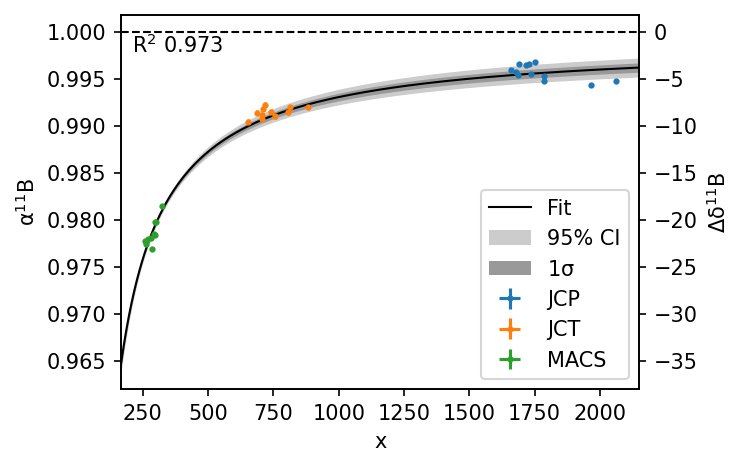

In [289]:
b_offset_table = make_b_offset_table(dat, '11B_10.115')
up = calc_b_offset_parameters(b_offset_table)

plot_b_offset_calibration(b_offset_table)

In [185]:
up

(0.16785388231417794+/-0.0035094556709972156,
 -0.0008439801479183114+/-0.0002538899379933762)

In [ ]:
NIST951a = 1 / 0.2473

srm_d11B = {
    # 'NIST612': un.ufloat(-0.26, 0.13/2),
    'NIST612': (un.ufloat(4.048, 0.001) / NIST951a - 1) * 1000,
    'MACS': un.ufloat(-0.57, 0.11/2),
    'JCT': un.ufloat(16.3, 0.55/2),
    'JCP': un.ufloat(24.3, 0.42/2),
    # 'UWC': un.ufloat(7.77, 0.89/2),
}

srm_colours = {
    'NIST612': 'C0',
    'MACS': 'C1',
    'JCT': 'C2',
    'JCP': 'C3',
    # 'UWC': 'C4',
}

srm_R11B = {k: (v / 1000 + 1) * NIST951a for k, v in srm_d11B.items()}

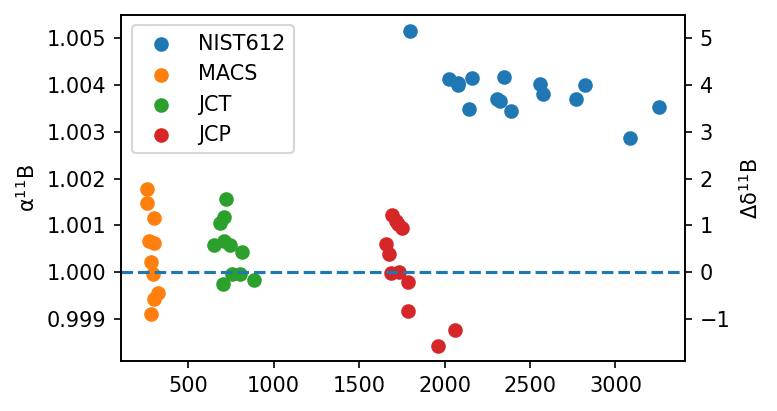

In [375]:
fig, ax = plt.subplots()

# samples = [s for s in dat.samples if 'JCT' in s or 'UWC' in s or 'JCP' in s or 'MACS' in s]
# samples = dat.samples

for srm in srm_d11B:
    samples = [s for s in dat.samples if srm in s]

    for s in samples:
        d = dat.data[s]
        # x = np.nanmean(d.data['ratios']['11B_10.54'])
        x = np.nanmean(d.data['ratios']['11B_10.115'])
        y = np.nanmean(d.data['d11b_corrected']['11B_10B']) / srm_R11B[srm]
        # y = np.nanmean(d.data['calibrated']['11B_10B']) / srm_R11B[srm]
        ax.scatter(la.nominal_values(x), la.nominal_values(y), color=srm_colours[srm])

for k, v in srm_colours.items():
    ax.scatter([],[], color=v, label=k)

ax.axhline(1, ls='--', color=srm_colours['NIST612'])

ax.set_ylabel(r'$\alpha^{11}B$')

tax = ax.twinx()
ylim = (np.array(ax.get_ylim()) - 1) * 1000
yticks = (ax.get_yticks() - 1) * 1000 

tax.set_yticks(yticks)
tax.set_ylim(ylim)

tax.set_ylabel(r'$\Delta \delta^{11}B$')
x
ax.legend()

In [ ]:
fig, ax = plt.subplots()

for srm in srm_d11B:
    samples = [s for s in dat.samples if srm in s]

    for s in samples:
        d = dat.data[s]
        # x = np.nanmean(d.data['ratios']['11B_10.54'])
        x = np.nanmean(d.data['ratios']['11B_10.115'])
        y = np.nanmean(d.data['calibrated']['11B_10B'])
        ax.scatter(la.nominal_values(x), la.nominal_values(y), color=srm_colours[srm])
    
    ax.axhline(la.nominal_values(srm_R11B[srm]), ls='--', color=srm_colours[srm], label=srm)
    
ax.legend()

In [866]:
srm_R11B['JCT']

4.109583501819652+/-0.0011120097048119694

In [29]:
# dat.trace_plots()